# Time-series Prediction

A time series is a sequence of observations, ordered in time. Forecasting involves training a model on historical data and using them to predict future observations. A simple example is a linear auto-regressive model. The linear auto-regressive (AR) model of a time-series $Z_t$ with $t=1,2,\dots,\infty$ is given by

$$\hat{z}_t = a_1 z_{t-1} + a_2 z_{t-2} + \cdots + a_p z_{t-p},$$

with $a_i \in \mathbb{R}$ for $i=1, \dots, p$ and $p$ the model lag. The prediction for a certain time $t$ is equal to a weighted sum of the previous values up to a certain lag $p$. In a similar way, the nonlinear (NAR) variant is described as

$$\hat{z}_t = f(z_{t-1}, z_{t-2}, \dots, z_{t-p}).$$

The figure below visualizes this process.

<img src="https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/assets/nar.jpg" width="600">

Remark that in this way, the time-series identification can be written as a classical black-box regression modeling problem $\hat{y}_t=f(x_t)$ with $y_t=z_t$ and $x_t=[z_{t-1}, z_{t-2}, \dots, z_{t-p}]$. When preparing the dataset and applying train/validation/test splits, it is important to prevent *data leakage* by respecting the temporal information flow. More precisely, a datapoint $z_t$ should not be part of two splits &mdash; either as input $x_t$ or target $y_t$ &mdash; and training (or validation) sets should not contain datapoints that occur after test datapoints.

In this notebook, we work on the time-series prediction problem using a multilayer perceptron (MLP) and a long short-term memory network (LSTM).

## Colab Setup
This part is only required when running this notebook "in the cloud" on [Google Colab](https://colab.research.google.com). When running it locally, skip this part and go to the next section.

In [1]:
# Load some auxiliary files from github.
!wget https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/session2/SantaFe.npz

--2025-08-03 07:54:44--  https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/session2/SantaFe.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [application/octet-stream]
Saving to: ‘SantaFe.npz.1’

SantaFe.npz.1       100%[===================>]   1.56K  --.-KB/s    in 0s      

2025-08-03 07:54:44 (18.6 MB/s) - ‘SantaFe.npz.1’ saved [1598/1598]



## Setup
Import all the necessary modules used throughout this notebook and define some helper methods to work with timeseries data and visualize the results.

In [2]:
# Import the required modules for this notebook
%pip install tensorflow==2.12.1
from dataclasses import dataclass
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import TimeSeriesSplit

In [3]:
@dataclass
class Fold:
  train_idxs: np.ndarray
  val_idxs: np.ndarray

def prepare_timeseries(timeseries, lag, validation_size=0, validation_folds=0):
  # Generate train (and validation) sets for the given timeseries and lag
  data = scipy.linalg.hankel(timeseries[:-lag], timeseries[-lag-1:-1])
  targets = timeseries[lag:]
  if validation_size > 0 and validation_folds > 0:
    tss = TimeSeriesSplit(test_size=validation_size, gap=lag)
    tss.n_splits = validation_folds
    folds = [Fold(train_idxs, val_idxs) for (train_idxs, val_idxs) in tss.split(data)]
    return data, targets, folds
  return data, targets

def shift(window, values):
  # Append new values to the given window (dropping the oldest values)
  result = np.empty(window.shape)
  values = np.atleast_1d(values)
  s = values.shape[0]
  result[:-s] = window[s:]
  result[-s:] = values
  return result

def normalize(timeseries, params=None):
  # Apply z-score normalization to the given timeseries
  if params is None:
    params = (np.mean(timeseries), np.std(timeseries))
  mu, sigma = params
  normalized = (timeseries - mu) / sigma
  return normalized, params

def rescale(timeseries, params):
  # Rescale the normalized timeseries back to its original values
  mu, sigma = params
  rescaled = mu + timeseries * sigma
  return rescaled

In [4]:
def plot_history(history, title, filename=None):
  # Plot the train and validation loss curves
  fig, ax = plt.subplots(figsize=(10, 3))
  ax.semilogy(history.history['loss'], label='Train')
  if 'val_loss' in history.history:
    ax.semilogy(history.history['val_loss'], label='Validation')
  ax.legend()
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  plt.title(title)
  if filename is not None:
    plt.savefig(f"{filename}.svg")
  plt.show()

def plot_timeseries(timeseries_dict, title=None, filename=None, figsize=(10, 3)):
  # Plot the given timeseries
  fig, ax = plt.subplots(figsize=figsize)
  for label, (start, ts) in timeseries_dict.items():
    ax.plot(start + np.arange(len(ts)), ts, label=label)
  ax.legend()
  ax.set_xlabel('Timestep')
  ax.set_ylabel('Laser intensity')
  plt.title(title)
  if filename is not None:
    plt.savefig(f"{filename}.svg")
  plt.show()

## Santa Fe Laser Dataset
The Santa Fe laser dataset is obtained from a chaotic laser which can be described as a nonlinear dynamical system. The first $1000$ data points can be used for training and validation purposes. The aim is to predict the next $100$ points (it is forbidden to include these points in the training or validation sets!). Both datasets are stored in the `SantaFe.npz` file and are visualized below.

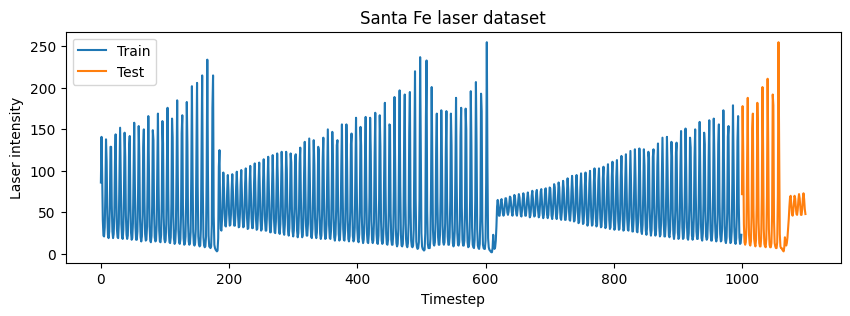

In [5]:
santafe = np.load('SantaFe.npz')
train_series = santafe['A']
test_series = santafe['Acont']
plot_timeseries({
    'Train': (0, train_series),
    'Test': (len(train_series), test_series)
}, 'Santa Fe laser dataset')

To train the various nonlinear autoregressive models, it will be useful to prepare the timeseries dataset beforehand. We start by normalizing the train and test sets.

In [6]:
normalized, params = normalize(santafe['A'])
normalized_test, _ = normalize(santafe['Acont'], params)

Next, the `prepare_timeseries` function is used to convert the timeseries into training data ($x_t$) and targets ($y_t$). Make sure you understand what the function does by trying it out on a small toy example.

In [7]:
timeseries = np.arange(10)  # Increase this number to create a larger time series
lag = 3  # Try different values for the lag
data, targets, folds = prepare_timeseries(timeseries, lag, validation_size=1, validation_folds=2)  # Examine the effect of the validation size and number of validation folds
print(f"Original timeseries: {timeseries}")
print(f"Data for lag {lag}: {data}")
print(f"Targets: {targets}")
for i, fold in enumerate(folds):
  print(f"Fold {i}:")
  print(f"  Train:     data={data[fold.train_idxs]}, targets={targets[fold.train_idxs]}")
  print(f"  Validate:  data={data[fold.val_idxs]}, targets={targets[fold.val_idxs]}")

Original timeseries: [0 1 2 3 4 5 6 7 8 9]
Data for lag 3: [[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]]
Targets: [3 4 5 6 7 8 9]
Fold 0:
  Train:     data=[[0 1 2]
 [1 2 3]], targets=[3 4]
  Validate:  data=[[5 6 7]], targets=[8]
Fold 1:
  Train:     data=[[0 1 2]
 [1 2 3]
 [2 3 4]], targets=[3 4 5]
  Validate:  data=[[6 7 8]], targets=[9]


Once you understand the dataset structure, apply it to the normalized Santa Fe timeseries. You can come back to these cells later to change the values of the lag or validation parameters.

In [8]:
# @title Parameters { run: "auto" }
lag = 10 # @param {type:"slider", min:1, max:100, step:1}
validation_size = 100 # @param {type:"slider", min:10, max:200, step:1}
validation_folds = 4 # @param {type:"slider", min:1, max:10, step:1}
# This is the hidden dimension of the MLP and LSTM networks trained later in this notebook
H = 20 # @param {type:"slider", min:10, max:100, step:1}

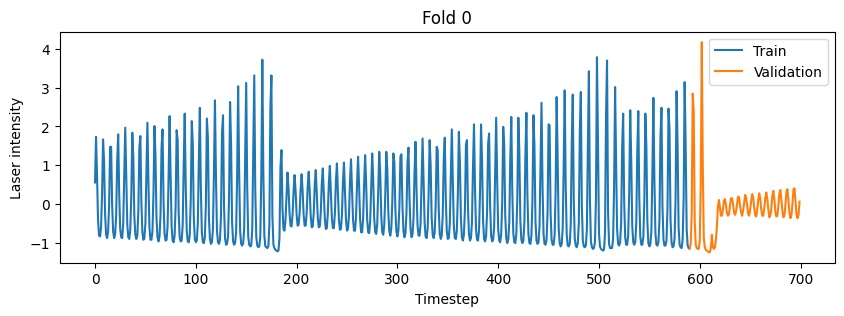

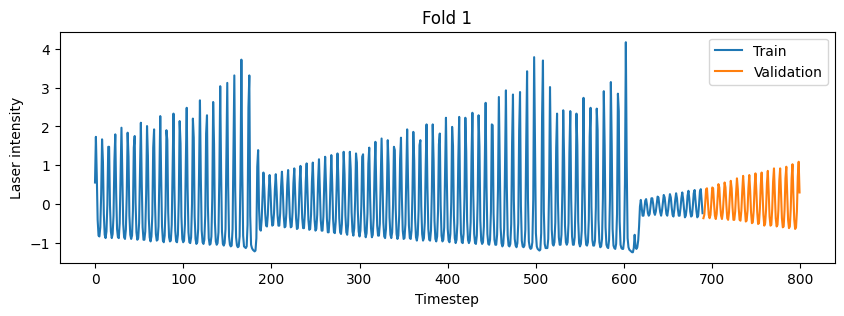

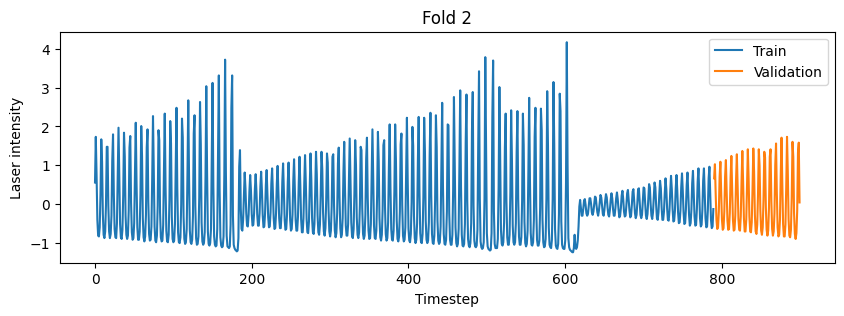

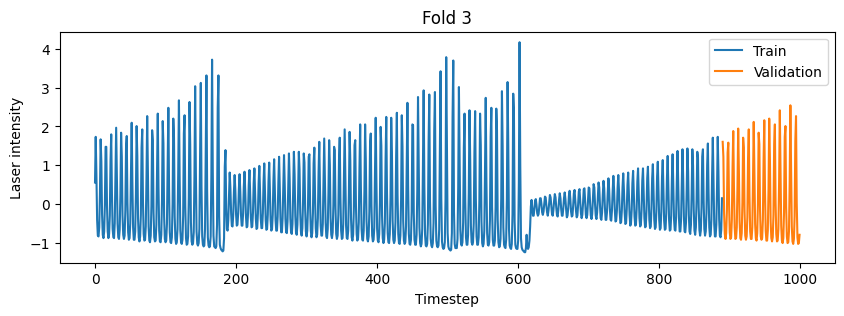

In [9]:
data, targets, folds = prepare_timeseries(normalized, lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])
  plot_timeseries({"Train": (0, train_series), "Validation": (len(train_series), val_series)}, f"Fold {f}")

## MLP
We now train a first nonlinear autoregressive (NAR) model on the training set and choose the hyperparameters based on the predictive performance on the validation sets. This first model is a multilayer perceptron (MLP) and training is done in feedforward mode using the prepared training set

$$\hat{z}_t = w^\top \tanh(V[z_{t-1}; z_{t-2}; \dots; z_{t-p}] + \beta).$$

In order to make predictions, the trained network is used in an iterative way as a recurrent network

$$\hat{z}_t = w^\top \tanh(V[\hat{z}_{t-1}; \hat{z}_{t-2}; \dots; \hat{z}_{t-p}] + \beta).$$

In [10]:
# Define the MLP network architecture
def MLP(input_dim, hidden_dim, output_dim, activation='tanh'):
  return keras.Sequential([
    keras.layers.Input(shape=[input_dim]),  # Expect input of shape (B, I) with B batch size, I input size
    keras.layers.Dense(units=hidden_dim, activation=activation),  # Output of shape (B, H) with H hidden feature size
    keras.layers.Dense(units=output_dim)  # Output of shape (B, O) with O output size
  ])

Train the MLP on the last training fold. You can later put this code in a `for` loop to train on each of the training folds for determining the optimal hyperparameters using $N$-fold cross-validation.

In [11]:
net = MLP(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
fold = folds[-1]
history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                  validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                  epochs=200, verbose=0)

Plot the train and validation loss curves.

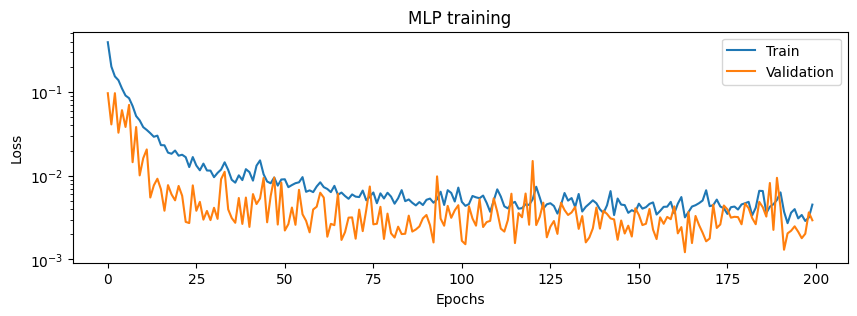

In [12]:
plot_history(history, "MLP training")

### **Exercise 1**
Investigate the model performance with different lags and number of neurons. Discuss how the model looks and explain clearly how you tune the parameters and what the influence on the final prediction is. Which combination of parameters gives the best performance (MSE) on the test set?

The MSE on the test set is: 5084.995


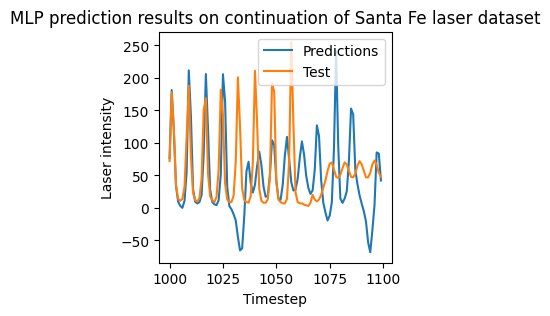

In [13]:
# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions (data is normalised, needs to be rescaled)
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Predictions": (1000, predictions_mlp), "Test": (1000, test_series)},
                title="MLP prediction results on continuation of Santa Fe laser dataset",
                figsize=(3,3))

## LSTM
We now train the second model, which is a Long Short Term Memory (LSTM) network. These are a special kind of RNN, capable of learning long-term dependencies. LSTMs contain information outside the normal flow of the recurrent network in a gated cell. Information can be stored in, written to, or read from a cell, much like data in a computer's memory. The cell makes decisions about what to store and when to allow reads, writes and erasures, via gates that open and close. Those gates act on the signals they receive, and similar to the neural network's nodes, they block or pass on information based on its strength and importance, which they filter with their own sets of weights. Those weights, like the weights that modulate input and hidden states, are adjusted via the recurrent network's learning process. That is, the cells learn when to allow data to enter, leave or be deleted through the iterative process of making guesses, backpropagating the error, and adjusting weights via gradient descent.

In [11]:
lag, H = 10, 50

In [12]:
# Define the LSTM network structure
def LSTM(input_dim, hidden_dim, output_dim):
  return keras.Sequential([
    keras.layers.Input(shape=[None, input_dim], batch_size=1),  # LSTM layer expects input of shape (B, T, F) with B batch size, T timesteps, F feature size
    keras.layers.LSTM(units=hidden_dim, return_sequences=True, stateful=True),  # Output of shape (B, T, H) with H hidden state size
    keras.layers.Dense(units=output_dim)  # Output of shape (B, T, O) with O output size
  ])

class LSTMCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.model.reset_states()  # Make sure the LSTM's hidden state is reset after every epoch

Train the LSTM on the last training fold. You can later put this code in a `for` loop to train on each of the training folds for determining the optimal hyperparameters using $N$-fold cross-validation.

In [16]:
net = LSTM(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
fold = folds[-1]
history = net.fit(
    data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
    validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
    epochs=150, callbacks=[LSTMCallback()], verbose=0)

Plot the train and validation loss curves.

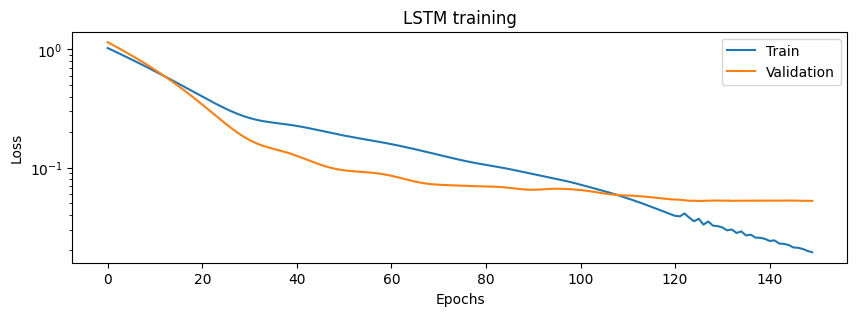

In [17]:
plot_history(history, "LSTM training")

### **Exercise 2**
Investigate the model performance with different lags and number of hidden states. Discuss how the model looks and explain clearly how you tune the parameters and what the influence on the final prediction is. Which combination of parameters gives the best performance (MSE) on the test set?

Compare the results of the recurrent MLP with the LSTM. Which model do you prefer and why?

The MSE on the test set is: 1701.732


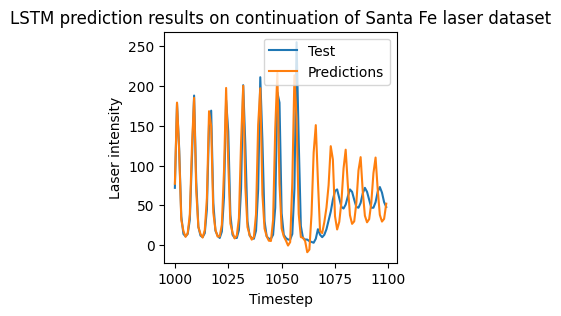

In [18]:
# LSTM Evaluation
# Note: Keras automatically updates the internal state of a stateful LSTM when you call .predict() or .fit(),
# but only if the model was built with stateful=True.
net.reset_states()
net.predict(data.reshape(1, -1, lag), verbose=0)
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, 1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions (data is normalised, needs to be rescaled)
predictions_lstm = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_lstm)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_lstm)},
                title="LSTM prediction results on continuation of Santa Fe laser dataset",
                figsize=(3,3))

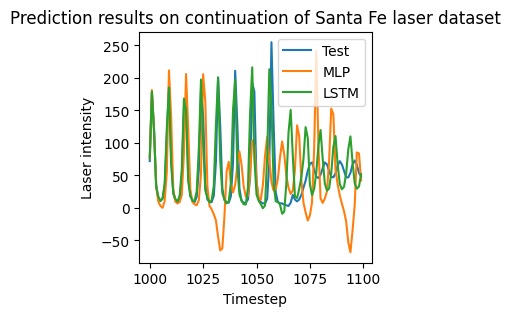

In [19]:
# Comparison of both models
plot_timeseries({"Test": (1000, test_series), "MLP": (1000, predictions_mlp), "LSTM": (1000, predictions_lstm)},
                title="Prediction results on continuation of Santa Fe laser dataset",
                figsize=(3,3))

## Exercises


Evaluating lag=10, H=10
Average validation loss: 0.04252663874649443


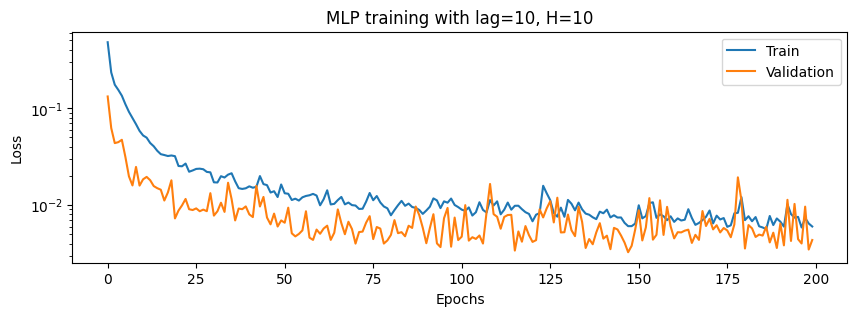

The MSE on the test set is: 7625.470


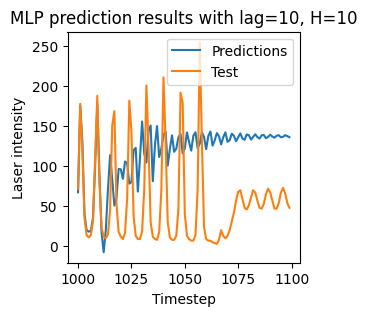


Evaluating lag=10, H=50
Average validation loss: 0.01768995582824573


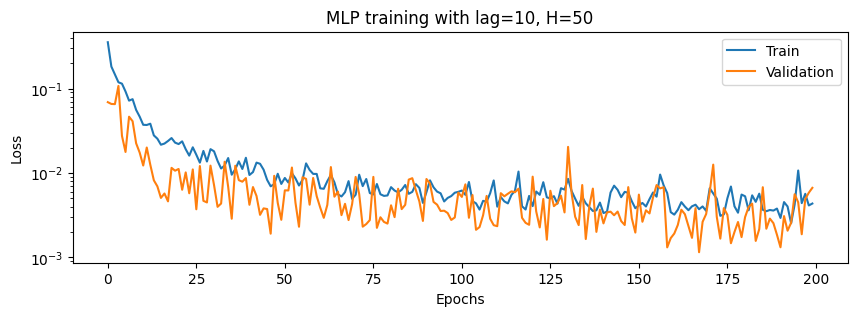

The MSE on the test set is: 7698.511


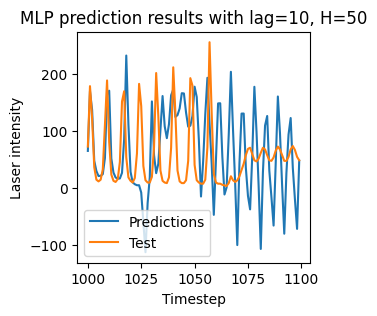


Evaluating lag=10, H=100
Average validation loss: 0.02729665586957708


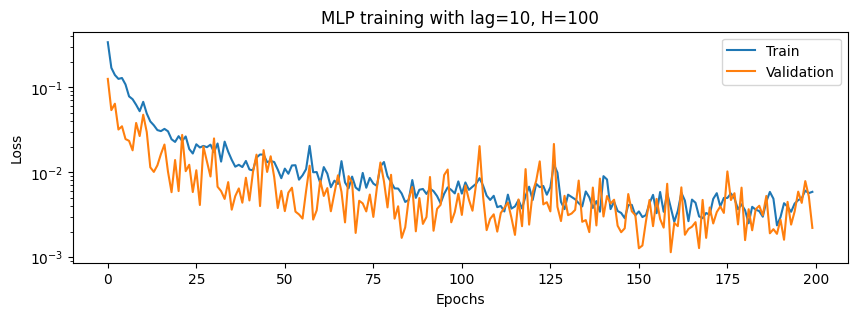

The MSE on the test set is: 3290.657


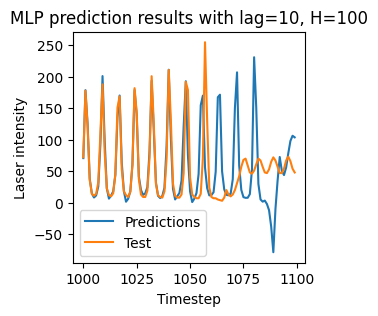


Evaluating lag=20, H=50
Average validation loss: 0.07629406306659803


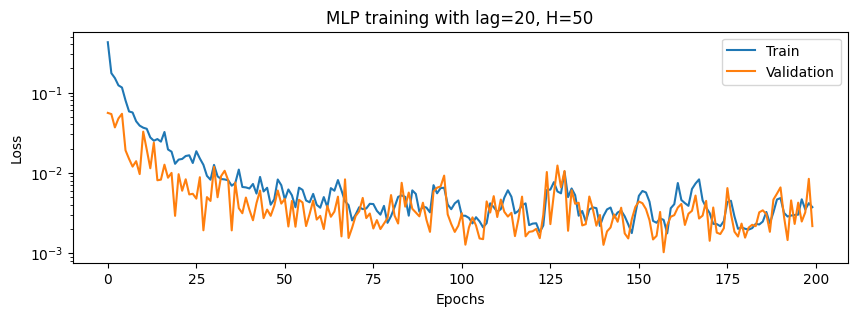

The MSE on the test set is: 4922.444


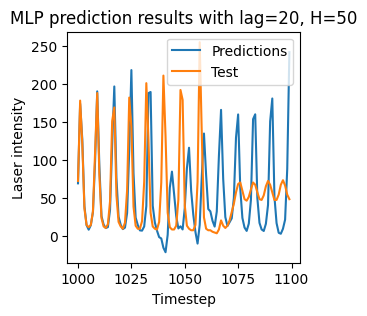


Evaluating lag=50, H=50
Average validation loss: 0.07624697202118114


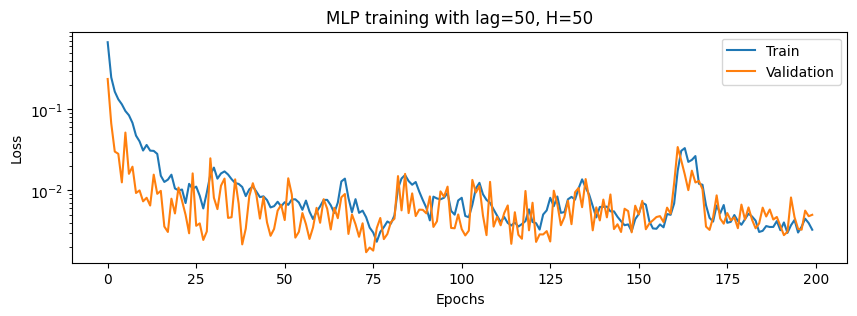

The MSE on the test set is: 2657.835


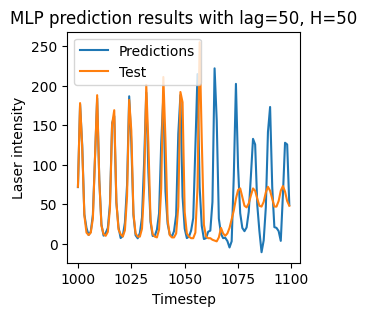


Evaluating lag=100, H=50
Average validation loss: 0.13154473202303052


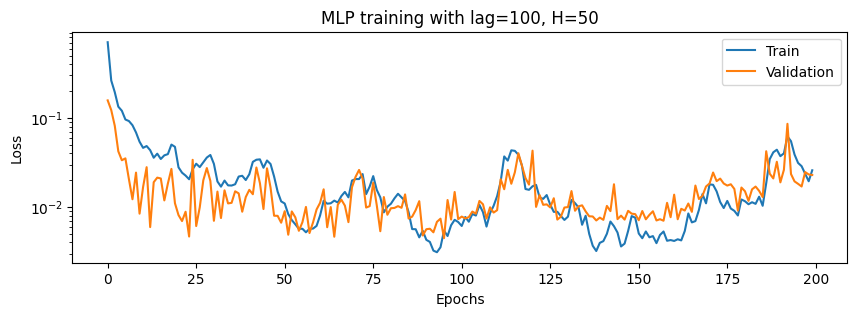

The MSE on the test set is: 2251.527


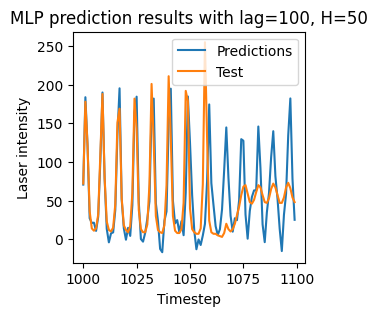

   lag    H  val_loss     test_mse
0   10   10  0.042527  7625.469914
1   10   50  0.017690  7698.511222
2   10  100  0.027297  3290.657417
3   20   50  0.076294  4922.444072
4   50   50  0.076247  2657.835015
5  100   50  0.131545  2251.526500


In [20]:
validation_size = 100
validation_folds = 4

results = []

for lag, H in [(10, 10), (10, 50), (10, 100),
               (20, 50), (50, 50), (100, 50)]:
  print(f"\nEvaluating lag={lag}, H={H}")

  data, targets, folds = prepare_timeseries(normalized, lag, validation_size, validation_folds)
  val_losses = []

  # Cross validation over folds for hyperparameter selection
  for f, fold in enumerate(folds):
    train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
    val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])
    # plot_timeseries({"Train": (0, train_series), "Validation": (len(train_series), val_series)}, f"Fold {f}")

    net = MLP(lag, H, 1)
    net.compile(
      loss=keras.losses.MeanSquaredError(),
      optimizer=keras.optimizers.Adam(learning_rate=0.01)
    )

    history = net.fit(
      data[fold.train_idxs], targets[fold.train_idxs],
      validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
      epochs=200, verbose=0
    )

    val_loss = net.evaluate(data[fold.val_idxs], targets[fold.val_idxs], verbose=0)
    val_losses.append(val_loss)

  avg_val_loss = np.mean(val_losses)
  print(f"Average validation loss: {avg_val_loss}")

  # Test evaluation (train representative single model on last fold, same as previously)
  fold = folds[-1]
  net = MLP(lag, H, 1)
  net.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01)
  )
  history = net.fit(
    data[fold.train_idxs], targets[fold.train_idxs],
    validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
    epochs=200, verbose=0
  )
  plot_history(history, f"MLP training with lag={lag}, H={H}")

  test_data = shift(data[-1], targets[-1])
  predictions = np.empty(normalized_test.shape)
  for t in range(len(predictions)):
    predictions[t] = net.predict(test_data.reshape((1, lag)), verbose=0).squeeze()
    test_data = shift(test_data, predictions[t])
  predictions_mlp = rescale(predictions, params)

  mse = np.mean((test_series - predictions_mlp) ** 2)
  print("The MSE on the test set is: {:.3f}".format(mse))

  plot_timeseries({"Predictions": (1000, predictions_mlp), "Test": (1000, test_series)},
                  title=f"MLP prediction results with lag={lag}, H={H}", figsize=(3, 3))

  results.append({
    "lag": lag,
    "H": H,
    "val_loss": avg_val_loss,
    "test_mse": mse
  })

print(pd.DataFrame(results))


Evaluating lag=10, H=10
Average validation loss: 0.0672710845246911


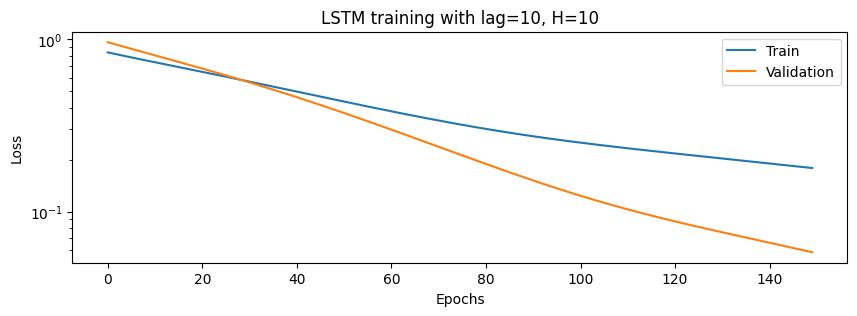

The MSE on the test set is: 3533.119


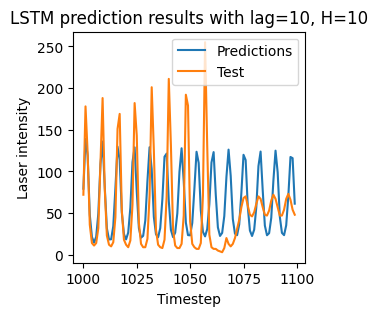


Evaluating lag=10, H=50
Average validation loss: 0.015281536034308374


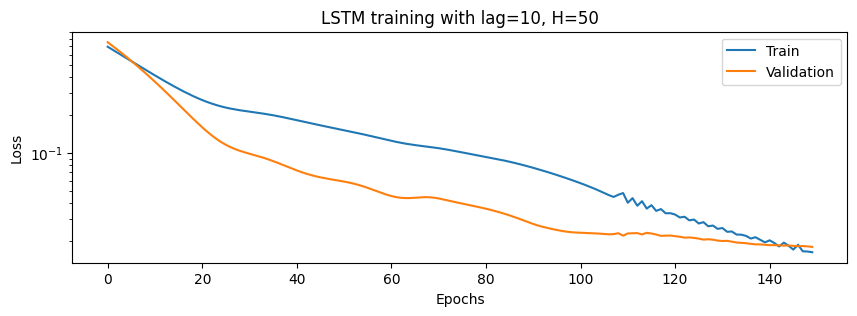

The MSE on the test set is: 1274.285


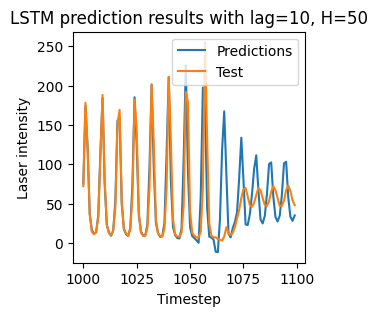


Evaluating lag=10, H=100
Average validation loss: 0.009709034697152674


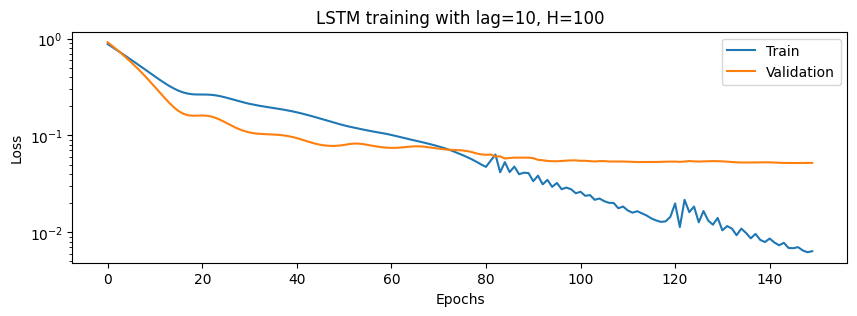

The MSE on the test set is: 872.449


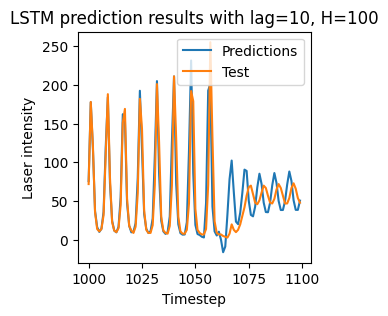


Evaluating lag=10, H=200
Average validation loss: 0.008571411482989788


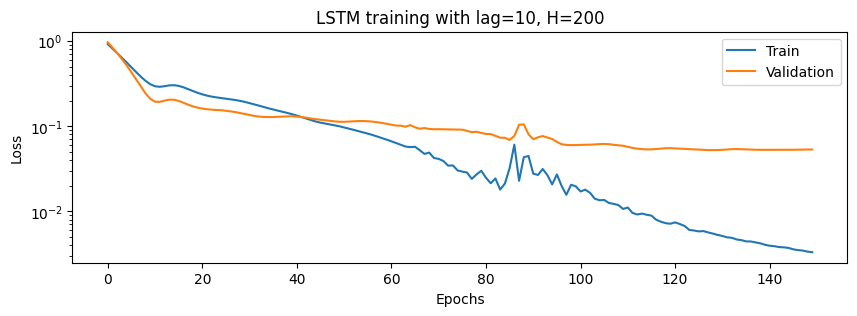

The MSE on the test set is: 1293.682


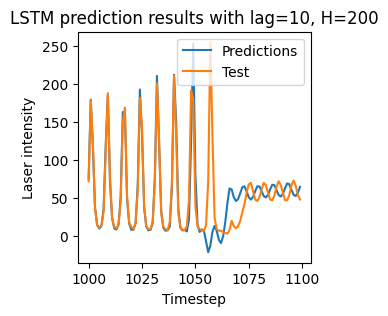


Evaluating lag=1, H=50
Average validation loss: 0.07158208452165127


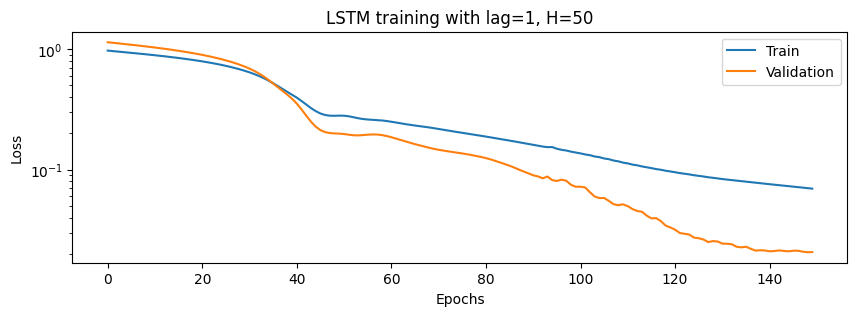

The MSE on the test set is: 1992.174


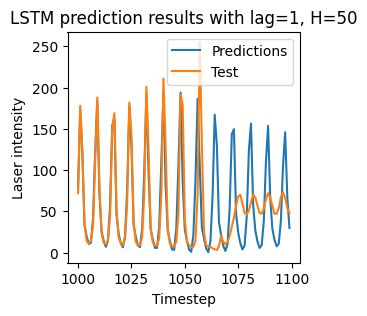


Evaluating lag=20, H=50
Average validation loss: 0.005031287670135498


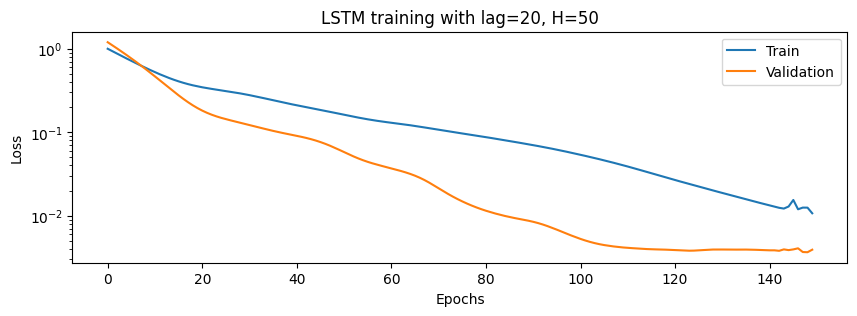

The MSE on the test set is: 1314.918


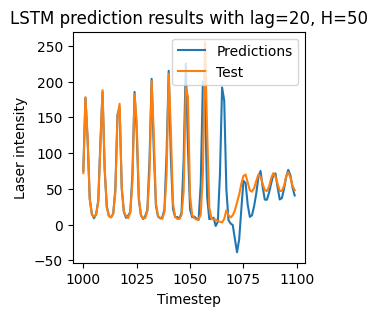


Evaluating lag=50, H=100
Average validation loss: 0.0029548442107625306


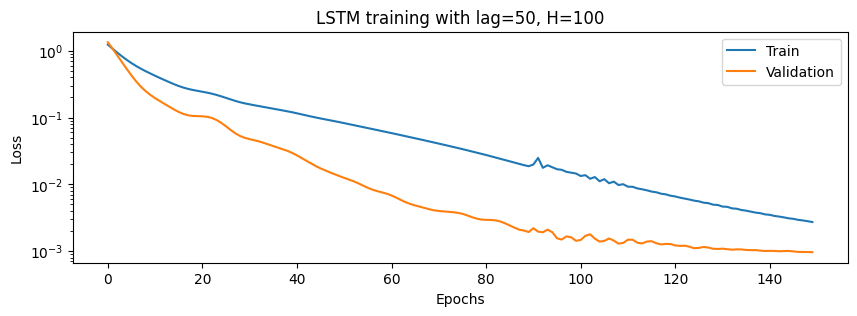

The MSE on the test set is: 114.479


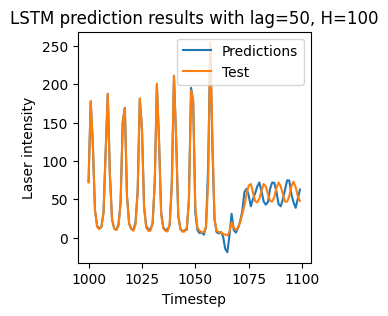

   lag    H  val_loss     test_mse
0   10   10  0.067271  3533.118649
1   10   50  0.015282  1274.285253
2   10  100  0.009709   872.449282
3   10  200  0.008571  1293.682081
4    1   50  0.071582  1992.174156
5   20   50  0.005031  1314.918007
6   50  100  0.002955   114.478901


In [21]:
validation_size = 100
validation_folds = 4

results = []

for lag, H in [(10, 10), (10, 50), (10, 100),  (10, 200),
               (1, 50), (20, 50), (50, 100)]:
  print(f"\nEvaluating lag={lag}, H={H}")

  data, targets, folds = prepare_timeseries(normalized, lag, validation_size, validation_folds)
  val_losses = []

  # Cross validation over folds for hyperparameter selection
  for f, fold in enumerate(folds):
    train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
    val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])
    # plot_timeseries({"Train": (0, train_series), "Validation": (len(train_series), val_series)}, f"Fold {f}")

    net = LSTM(lag, H, 1)
    net.compile(
      loss=keras.losses.MeanSquaredError(),
      optimizer=keras.optimizers.Adam(learning_rate=0.001)
    )
    fold = folds[-1]
    history = net.fit(
        data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
        validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
        epochs=150, callbacks=[LSTMCallback()], verbose=0)

    val_loss = net.evaluate(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1)), verbose=0)
    val_losses.append(val_loss)

  avg_val_loss = np.mean(val_losses)
  print(f"Average validation loss: {avg_val_loss}")

  # Test evaluation (train representative single model on last fold, same as previously)
  fold = folds[-1]
  net = LSTM(lag, H, 1)
  net.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
  )
  fold = folds[-1]
  history = net.fit(
      data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
      validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
      epochs=150, callbacks=[LSTMCallback()], verbose=0)
  plot_history(history, f"LSTM training with lag={lag}, H={H}")

  net.reset_states()
  net.predict(data.reshape(1, -1, lag), verbose=0)
  test_data = shift(data[-1], targets[-1])
  predictions = np.empty(normalized_test.shape)
  for t in range(len(predictions)):
    predictions[t] = net.predict(test_data.reshape((1, 1, lag)), verbose=0).squeeze()
    test_data = shift(test_data, predictions[t])

  predictions_lstm = rescale(predictions, params)
  mse = np.mean((test_series - predictions_lstm)**2)
  print("The MSE on the test set is: {:.3f}".format(mse))

  plot_timeseries({"Predictions": (1000, predictions_lstm), "Test": (1000, test_series)},
                  title=f"LSTM prediction results with lag={lag}, H={H}", figsize=(3,3))

  results.append({
    "lag": lag,
    "H": H,
    "val_loss": avg_val_loss,
    "test_mse": mse
  })

print(pd.DataFrame(results))

Comparison of selected models:

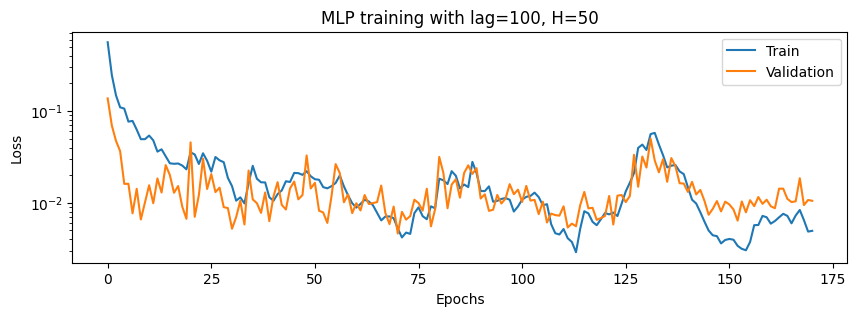

The MSE on the test set is: 2462.667


In [41]:
from keras.callbacks import EarlyStopping

validation_size = 100
validation_folds = 4

lag, H = 100, 50

data, targets, folds = prepare_timeseries(normalized, lag, validation_size, validation_folds)

# Test evaluation (train representative single model on last fold, same as previously)
fold = folds[-1]
net = MLP(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=100,
  restore_best_weights=True
)
history = net.fit(
  data[fold.train_idxs], targets[fold.train_idxs],
  validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
  epochs=500, verbose=0,
  callbacks=[early_stopping]
)
plot_history(history, f"MLP training with lag={lag}, H={H}")

test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])
predictions_mlp = rescale(predictions, params)

mse = np.mean((test_series - predictions_mlp) ** 2)
print("The MSE on the test set is: {:.3f}".format(mse))

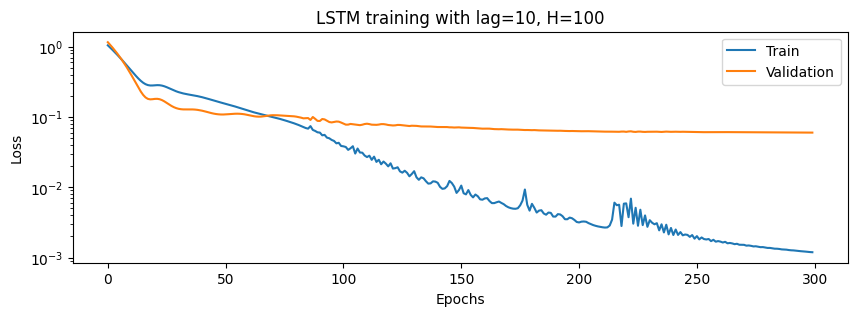

The MSE on the test set is: 1643.964


In [42]:
validation_size = 100
validation_folds = 4

lag, H = 10, 100

data, targets, folds = prepare_timeseries(normalized, lag, validation_size, validation_folds)

# Test evaluation (train representative single model on last fold, same as previously)
fold = folds[-1]
net = LSTM(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
fold = folds[-1]
early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=50,
  restore_best_weights=True
)
history = net.fit(
  data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
  validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
  epochs=300, callbacks=[LSTMCallback(), early_stopping], verbose=0)
plot_history(history, f"LSTM training with lag={lag}, H={H}")

net.reset_states()
net.predict(data.reshape(1, -1, lag), verbose=0)
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, 1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

predictions_lstm = rescale(predictions, params)
mse = np.mean((test_series - predictions_lstm)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

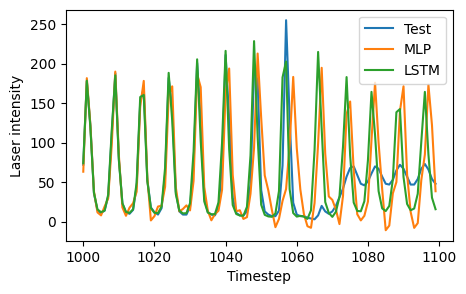

In [43]:
# Comparison of both models
plot_timeseries({"Test": (1000, test_series),
                 "MLP": (1000, predictions_mlp),
                 "LSTM": (1000, predictions_lstm)},
                figsize=(5,3))

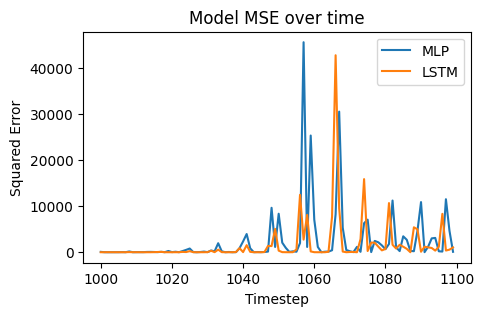

In [44]:
def plot_mse_over_time(predictions_dict, target_series, start=0, title=None, filename=None, figsize=(10, 3)):
  fig, ax = plt.subplots(figsize=figsize)
  t = np.arange(start, start + len(target_series))

  for label, preds in predictions_dict.items():
    mse_series = (preds - target_series) ** 2
    ax.plot(t, mse_series, label=label)

  ax.legend()
  ax.set_xlabel('Timestep')
  ax.set_ylabel('Squared Error')
  plt.title(title or "MSE over time")
  if filename is not None:
    plt.savefig(f"{filename}.svg")
  plt.show()

plot_mse_over_time(predictions_dict={"MLP": predictions_mlp, "LSTM": predictions_lstm},
    target_series=test_series, start=1000, figsize=(5, 3), title="Model MSE over time")

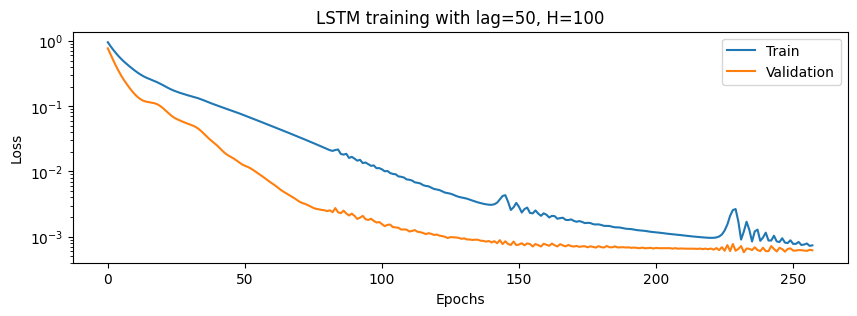

The MSE on the test set is: 418.086


In [45]:
validation_size = 100
validation_folds = 4

lag, H = 50, 100

data, targets, folds = prepare_timeseries(normalized, lag, validation_size, validation_folds)

# Test evaluation (train representative single model on last fold, same as previously)
fold = folds[-1]
net = LSTM(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
fold = folds[-1]
early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=25,
  restore_best_weights=True
)
history = net.fit(
  data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
  validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
  epochs=300, callbacks=[LSTMCallback(), early_stopping], verbose=0)
plot_history(history, f"LSTM training with lag={lag}, H={H}")

net.reset_states()
net.predict(data.reshape(1, -1, lag), verbose=0)
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, 1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

predictions_lstm = rescale(predictions, params)
mse = np.mean((test_series - predictions_lstm)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

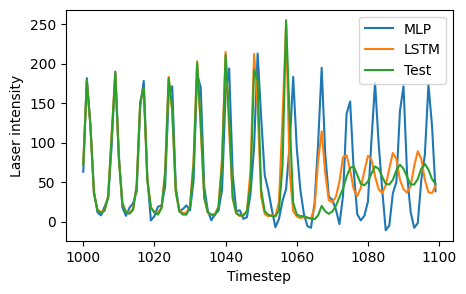

In [48]:
# Comparison of both models
plot_timeseries({"MLP": (1000, predictions_mlp),
                 "LSTM": (1000, predictions_lstm),
                 "Test": (1000, test_series)},
                 figsize=(5,3))

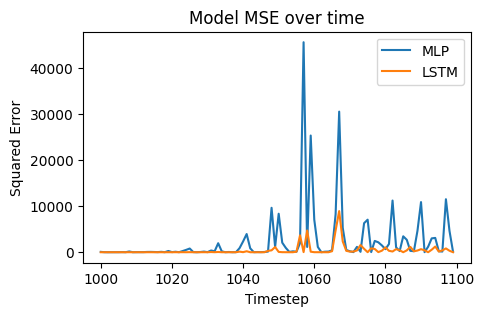

In [49]:
def plot_mse_over_time(predictions_dict, target_series, start=0, title=None, filename=None, figsize=(10, 3)):
  fig, ax = plt.subplots(figsize=figsize)
  t = np.arange(start, start + len(target_series))

  for label, preds in predictions_dict.items():
    mse_series = (preds - target_series) ** 2
    ax.plot(t, mse_series, label=label)

  ax.legend()
  ax.set_xlabel('Timestep')
  ax.set_ylabel('Squared Error')
  plt.title(title or "MSE over time")
  if filename is not None:
    plt.savefig(f"{filename}.svg")
  plt.show()

plot_mse_over_time(predictions_dict={"MLP": predictions_mlp, "LSTM": predictions_lstm},
    target_series=test_series, start=1000, figsize=(5, 3), title="Model MSE over time")